## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_collab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
import os
import sys

if not os.path.exists("sam_vit_h_4b8939.pth"):

    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
    
    !wget https://github.com/JordanMakesMaps/Fast-Multilevel-Superpixel-Segmentation/archive/refs/heads/master.zip
    !unzip "master.zip"

images_path = "Fast-Multilevel-Superpixel-Segmentation-master/Notebooks/MLC/images/"
labels_path = "Fast-Multilevel-Superpixel-Segmentation-master/Notebooks/MLC/labels/"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-w6octhv3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-w6octhv3
  Resolved https://github.com/facebookresearch/segment-anything.git to commit f58f1d1cd1b790b0d5214ae6e80dfbb1d4f19d39
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36582 sha256=557e2f975249cd0bc320d33b38887e38e24c59050fa3d0377f3107675b4b0da8
  Stored in directory: /tmp/pip-ephem-wheel-cache-0s5inixg/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segment-anything
--2023-04-10 14:46:26--  https://dl.fbaipublicfiles.com/segment_anything/s

## Set-up

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())


PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True


In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


def color_mask(mask, color_dict):

  colored_mask = np.zeros(shape=(mask.shape[0:2]) + (3,), dtype=np.uint8)

  for class_val in np.unique(mask):
    class_label = list(color_dict.keys())[class_val]
    class_color = (color_dict[class_label] * 255).astype(np.uint8)
    colored_mask[mask == class_val, :] = class_color
    
  return colored_mask

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

<ipython-input-27-80468c3537ba>:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  y, x, l = pd.read_csv(label_path, sep="; ").to_numpy().T


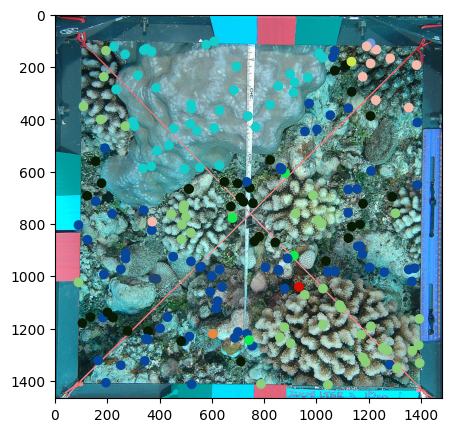

In [ ]:
import glob
import pandas as pd

# Get the file paths
images = sorted(glob.glob(images_path + "*"))
labels = sorted(glob.glob(labels_path + "*"))

i = 0

rescale_factor = 0.75

# Access one of of the examples
image_path = images[i]
label_path = labels[i]

# Get the XY labels
y, x, l = pd.read_csv(label_path, sep="; ").to_numpy().T
y = (y * rescale_factor).astype(int)
x = (x * rescale_factor).astype(int)
l = np.array([_.strip() for _ in l])

# Get the class categories, create a dict
class_categories = np.unique(l).tolist()
class_categories.insert(0, "Background")
class_categories = [c.strip() for c in class_categories]
class_dict = {c:i for i, c in enumerate(class_categories)}

# Open the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
image = cv2.filter2D(src=image, ddepth=-100, kernel=kernel)
image = cv2.resize(image, (0, 0), fx = rescale_factor, fy = rescale_factor)

# Generate a dictionary that maps each class label to a random color
color_dict = {c: np.random.rand(3) for c in class_categories}
color_dict['Background'] = np.array([0, 0, 0])
colors = [color_dict[label] for label in l]

# Plot the image and scatter plot the points based on label value
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.scatter(x, y, c=colors)
plt.axis('on')
plt.show()

To generate masks, just run `generate` on an image.

In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=48,
    points_per_batch=128,
    pred_iou_thresh=0.10,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=10,  # Requires open-cv to run post-processing
)

masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())

716
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
# Define a function to generate a 2D grid of indices within a circular region
def circle_mask(shape, center, radius):
    x_indices, y_indices = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    return (x_indices - center[1])**2 + (y_indices - center[0])**2 <= radius**2

# Create a mask to hold all of the results
final_mask = np.zeros(shape=(image.shape[0],
                             image.shape[1],
                             len(class_categories)), dtype=np.uint8)
# size = 50

# # Loop over each point
# for i in range(len(l)):
#     # Get the points
#     y_ = y[i]
#     x_ = x[i]
#     # Get the class category
#     class_val = class_dict[l[i]]
#     # Add the masked class label to the final mask
#     mask = circle_mask(image.shape[:2], (y_, x_), size)
#     final_mask[mask, class_val] = class_val

# Loop through all the masks
for mask_id, mask in enumerate(masks):
  # Get the segmentation mask
  m = mask['segmentation']
  # Find the indices containing labeled points
  indices_in_mask = np.where(m[y, x])[0]
  # Skip this mask if no points are in it
  if len(indices_in_mask) == 0:
    continue

  # Get the labels in the mask
  labels_in_mask = l[indices_in_mask]
  # Get the unique values and their counts
  unique, counts = np.unique(labels_in_mask, return_counts=True)
  # Find the index of the most occurring value
  mode_index = np.argmax(counts)
  # Get the most occurring value
  mode_label = unique[mode_index]
  # Get the number value representing mode label
  class_val = class_dict[mode_label]
  # Assign the class value in the mask dict
  mask['class_label'] = mode_label
  mask['clas_value'] = class_val
  # Fil the final mask with the label value
  final_mask[:, :, class_val][m] = class_val

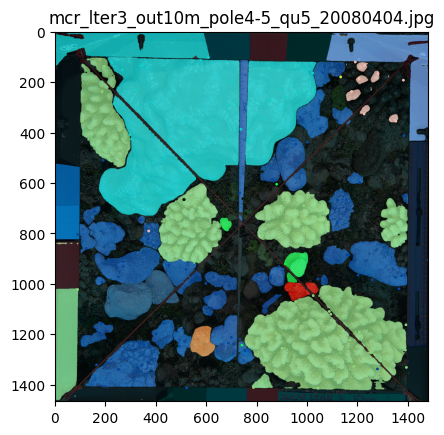

In [ ]:
plt.figure()
plt.title(os.path.basename(image_path))
plt.imshow(image)
plt.imshow(color_mask(np.argmax(final_mask, axis=2), color_dict), alpha=.75)
plt.scatter(x, y, s=1, c=colors)
plt.show()